# South Park network analysis
South park is an animated sitcom created by Trey Parker and Matt Stone. The Show debuted on August 13, 1997 and there has been produced 23 seasons and 2 specials since. South Park is about the 4 friends, Eric Cartman, Stan Marsh, Kyle Broflovski and Kenny McCormick. The show is characterized by having many odd and improbable characters that is both made up, but also includes parodies of celebrities and public figures. The show often involves with controversy and taboo subjects. 

### Our inspiration
South park is a tv show that has existed as long as we can remember, we have therefore grown up with it. South park has a tendency to make shock value humor which speaks to a lot of young people. "The fuck everything" kind of mentality is excatly what we find fun and entertaining. The show has evolved through the years, we therefore thought it would be interesting to dig into how the characters interlink with each other and how the language has changed thorugh the seasons. 

### Goal for the project 
This notebook will give an introduction to the south park network. It will look at how characters interlink with each other and show stats from the network. It consists of commentary and explanations of the analysis. The analysis will be on basic stats, but will also dig into sentiment analysis of the main characters and how their language evolve through the seasons. The characters categories, which appear on the wiki page, will also be investigated to see if they correspond to the communities that can be found from the GCC. 


# Basic stats 
The dataset is from southpark.fandom.com where we download all character pages and episode scripts. A character link to another character if the other character is mentioned in its character page. This way a digraph can be created for characters that interact with each other.
A csv file called ["characters.csv"](https://github.com/koldbrandt/socialgraphs/blob/main/characters.csv) has been created. The csv has a column with the character name and another column with a list containing the characters that the character link to. The 4 other columns are the characters categories. Where 'mainCategories' are all its categories and 'subCategory1' refers to its primary category.  
The directed network has been created and the gcc has been found. Both of them are saved in the github as a pickle file. The files can be found [here](https://github.com/koldbrandt/socialgraphs/tree/main/network).

### Getting the data and cleaning

First we needed to get all the characters from the show. Looking at the characters page of the fandom wiki we noticed that all character names/pages are reffered the same way by having `[[character name]]`. This made for a simple regular expression to get all of these and then removing the '[' and ']'.  
The regular expression looks like the following:  
`'\[\[[a-zA-Z0-9\'\\ -.]*\]\]'`  
This simply states that we get a word or multiple inside double square brackets. The words can have some special characters, which is listed in the regular expression. From this we get 1837 different characters. where they each have different categories which we will come back to later. 

Now when all character names has been found the character page can be downloaded and saved as txt. The downloaded pages ca be found on the github. From these pages a digraph can be created. This will be done by finding all links to other characters on the characters page and then create a directed link between them. To subtract the links a regex has been used. The pattern for a link is as followed `[[character name|alias]]` and sometimes just with the character name. This gives a very smiliar regex as used earlyer, just with some more special characters in it and then some more cleaning is used afterwards. The regex looks like the following:  
`\[\[*[A-Za-z _()\|\']*\]\]`  
From this the links just have to get split by '[', ']' and '|'. Then the link can be taken out and a graph can be created. The csv file mentioned earlier has all the characters that it links to in a column. 

To see how all characters and their pages has been download look [here](https://github.com/koldbrandt/socialgraphs/blob/main/SP_get_characters.ipynb).

### Undirected graph 
Some basic stats for the undirected graph will now be shown and commented.

In [1]:
import requests
import re
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
from fa2 import ForceAtlas2
import seaborn as sns
from ast import literal_eval
import numpy as np
import pickle
from pprint import pprint
from community import community_louvain
from PIL import Image
from math import log
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import random
from nltk import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from math import log
from nltk import FreqDist
import nltk
from wordcloud import WordCloud
import random 
from matplotlib import colors as mcolors
sns.set()

Loading in the undirected GCC.

In [35]:
G = nx.read_gpickle("network/SouthParkUnirectedGCC.gpickle")

 We will start with showing some stats on the network. Here are number of nodes, edges and a list of the 5 most connected characters.

In [36]:
def printBasicStatsUD(G):
    print("Basic stats for the gcc network:")
    N = len(G.nodes())
    K = sum(dict(G.degree()).values())/N
    d = log(N)/log(K)
    print("Number of nodes: ", N)
    print("Number of edges: ", len(G.edges()))
    print("Average degree: ", K)
    print("Average distance between 2 nodes: ", d)
    print("\n5 most connected characters: " )
    degree_list = sorted(G.degree, key=lambda x: x[1], reverse=True)
    for node, degree in degree_list[0:5]:
        print(f'{node}: {degree} edges')
printBasicStatsUD(G)

Basic stats for the gcc network:
Number of nodes:  1551
Number of edges:  5652
Average degree:  7.288201160541586
Average distance between 2 nodes:  3.698743942239915

5 most connected characters: 
Eric Cartman: 522 edges
Stan Marsh: 348 edges
Kyle Broflovski: 298 edges
Butters Stotch: 239 edges
Randy Marsh: 233 edges


When looking at the 5 most connected characters then it is interesting that Kenny McCormick is not one of them, since he is one of the 4 main characters of the show. An explanation to this could be that he never really talks in the show, but he mumbles through everything and it can therefore be hard to understand the character. Butters and Randy are highly connected since they are a big part of the show. 

We want to show the degree distribution of the network.

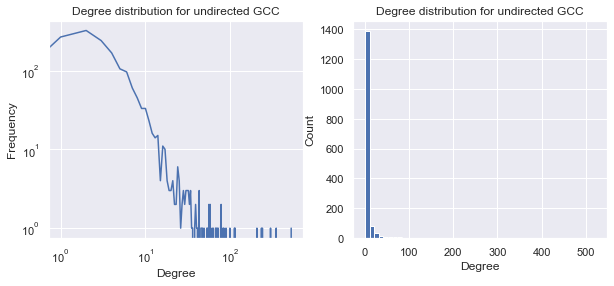

In [5]:
f, ax = plt.subplots(1, 2, figsize=(10, 4))
degree_freq = nx.degree_histogram(G)
degrees = range(len(degree_freq))
ax[0].loglog(degrees, degree_freq,'-') 
ax[0].set_xlabel('Degree')
ax[0].set_ylabel('Frequency')
ax[0].set_title("Degree distribution for undirected GCC")
degrees = [val for (node, val) in G.degree()]
d1 = np.array(degrees)
ax[1].hist(d1, bins = 50) 
ax[1].set_xlabel('Degree')
ax[1].set_ylabel('Count')
_= ax[1].set_title("Degree distribution for undirected GCC")

The degree distrbibution tells us that the network is not random. This is expected since we have some characters that are in every episode of the show and a lot of characters that only show in a single episode or a few. This gives a very uneven distribution through the network. 

Now we can plot the network using forceatlas2. The nodes will be colored in regards to their category and the size of nodes will be found from its degree. 

setting node size depending on degree

In [37]:
d = dict(G.degree)
node_sizes = [8*v for v in d.values()]

Loading in the csv files with all characters and their category

In [38]:
df_characters =  pd.read_csv('characters.csv')

Making a list of colors for each edge. This is done by making a dictionary where key is category and value is a color. Then mapping each node together with a color depending on its category.

In [39]:
categories = list(set(df_characters.subCategory1.values))
num_colors=len(set(categories))
colors=list(mcolors.CSS4_COLORS.keys())
cluster_colors=random.choices(colors, k=num_colors)

color_dict = {}
for i in range(len(categories)):
    color_dict[categories[i]] = cluster_colors[i]

node_color = []
for node in G.nodes():
    cat = df_characters[df_characters.Name == node].subCategory1.values[0]
    node_color.append(color_dict[cat])

It can now be plottet using forceatlas 2

In [40]:
# Setup FA2 w. parameters
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,    # Dissuade hubs
    edgeWeightInfluence=1.0,

    # Performance
    jitterTolerance=1.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,

    # Tuning
    scalingRatio=1.0,
    strongGravityMode=False,
    gravity=0.2,

    # Log
    verbose=True

    
)

# compute node positions with the fa algorithm
node_pos = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:26<00:00, 74.49it/s]

BarnesHut Approximation  took  8.09  seconds
Repulsion forces  took  17.22  seconds
Gravitational forces  took  0.14  seconds
Attraction forces  took  0.07  seconds
AdjustSpeedAndApplyForces step  took  0.71  seconds


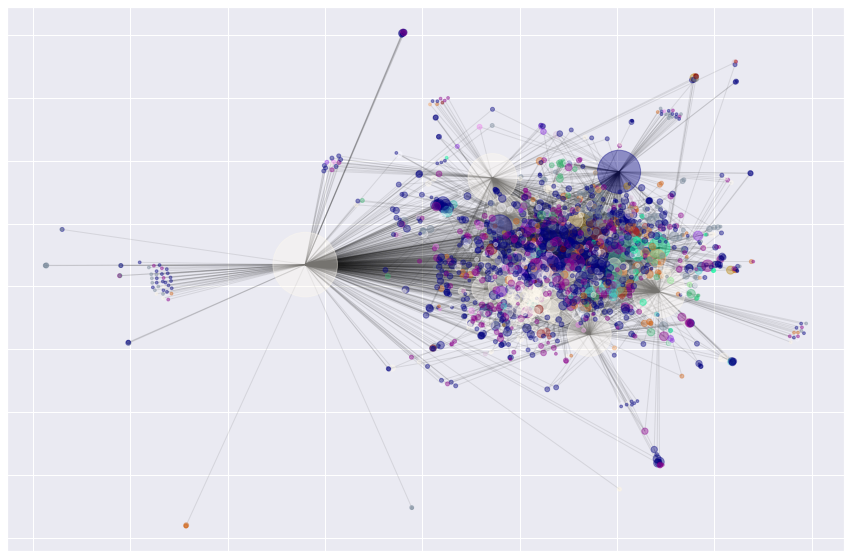

In [41]:
plt.figure(figsize=(15, 10))
_ = nx.draw_networkx_nodes(G, node_pos, nodelist=d.keys(), node_size=node_sizes, alpha=0.4, node_color = node_color)
_ = nx.draw_networkx_edges(G, node_pos, alpha=0.1)

From this it is clear to see that there are a handfull of hubs that almost all other nodes connect to. This is also what we saw when looking at the degree distribution plot, that there were a few characters that had a lot of nodes connected to them. There are also a lot of nodes with only a few edges, which is expected since some characters are only part of 1 or a few episodes. The hubs have the same color, which makes sense since they primarily have the category '4.th grader'.

### Directed Graph
We will now look at the basic stats for the directed GCC. We are starting by loading it in and getting the basic stats for the graph. 

Starting by loading in the directed gcc

In [13]:
G = nx.read_gpickle("network/SouthParkDirectedGCC.gpickle")

Printing some basic stats for the network.

In [14]:
def printBasicStats(G):
    print("Basic stats for the gcc network:")
    N = len(G.nodes())
    K = sum(dict(G.degree()).values())/N
    d = log(N)/log(K)
    print("Number of nodes: ", N)
    print("Number of edges: ", len(G.edges()))
    print("Average degree: ", K)
    print("Average distance between 2 nodes: ", d)
    print("\n5 most in degree: " )
    in_deg = sorted(G.in_degree, key=lambda x: x[1], reverse=True)
    for node, degree in in_deg[0:5]:
        print(f'{node}: {degree} edges')
    print("\n5 most out degree: " )
    out_deg = sorted(G.out_degree, key=lambda x: x[1], reverse=True)
    for node, degree in out_deg[0:5]:
        print(f'{node}: {degree} edges')
    
printBasicStats(G)

Basic stats for the gcc network:
Number of nodes:  1551
Number of edges:  6635
Average degree:  8.555770470664088
Average distance between 2 nodes:  3.4224516682951642

5 most in degree: 
Eric Cartman: 509 edges
Stan Marsh: 341 edges
Kyle Broflovski: 294 edges
Butters Stotch: 230 edges
Randy Marsh: 222 edges

5 most out degree: 
Eric Cartman: 88 edges
Heidi Turner: 74 edges
Douchebag: 44 edges
Stan Marsh: 41 edges
Randy Marsh: 40 edges


This shows that there are 996 more edges in the directed graph. Average degree is higher since we can have edges going both ways between nodes. The average distance between 2 nodes are about the same as in the undirected, this is expected.  
The 5 most connected characters in regards to in degree are actually same as in the undirected graph. That is the same characters is somewhat expected since they are main characters in the show. The 5 most connected characters in regard to out degree is a bit more surprising since Heidi turner and douchebag is in the list. Heidi Turner is a main character in the series and is the most popular girl in the 4.th grade, and therefore it makes a bit sense that she has a lot of out degrees. Douchebag or "The new kid" as he is also known by is from the two video games that has been created. It does therefore also make sense that he is a key person in the network.

Lets look at the degree distribution of both in degree and out degree. 

In [15]:
degrees_in = np.array([d for _, d in G.in_degree])
degrees_out = np.array([d for _, d in G.out_degree])
in_deg, in_deg_count = np.unique(degrees_in, return_counts=True)
out_deg, out_deg_count = np.unique(degrees_out, return_counts=True)

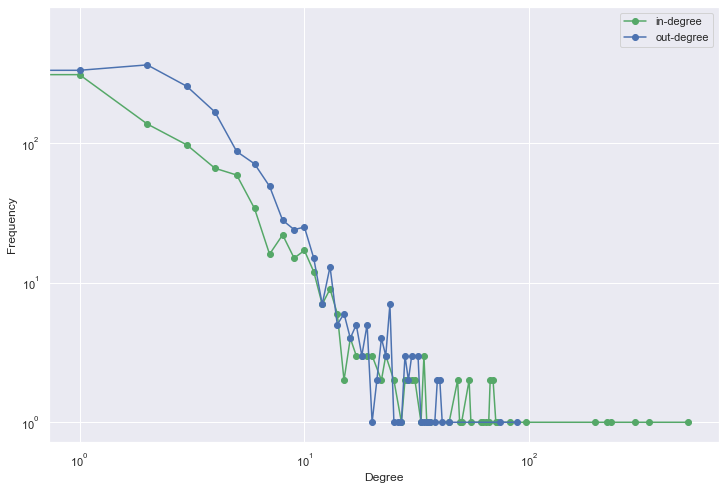

In [16]:
plt.figure(figsize=(12, 8)) 
plt.loglog(in_deg, in_deg_count, 'go-', label='in-degree') 
plt.loglog(out_deg, out_deg_count, 'bo-', label='out-degree')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()
_ = plt.show

As the plot shows then in and out degree do follow each other pretty well. It shows that the hubs or main characters has a lot more in degrees than the rest of the network and lays flat on on the x axis. There is a lot of characters with a single or a few links, which also makes sense since there are characters only showing in a single or a few episodes.  

Now we can plot the network using forceatlas2. The nodes will be colored in regards to their category, the edges will be the color that the node that it pointing to has and the size of nodes will be found from its degree. 

Getting the degree for every node to calculate the size

In [17]:
d = dict(G.degree)
node_sizes = [8*v for v in d.values()]

Using the same colors from the plot for the undirected gcc. This means that we only have to find the colors for the edges now. 

In [18]:
edges = G.edges
color_list_edge = []
for e,p in edges:
    cat = df_characters[df_characters.Name == p].subCategory1.values[0]
    #node_color.append(color_dict[cat])
    color_list_edge.append(color_dict[cat])

The network can now be plottet. 

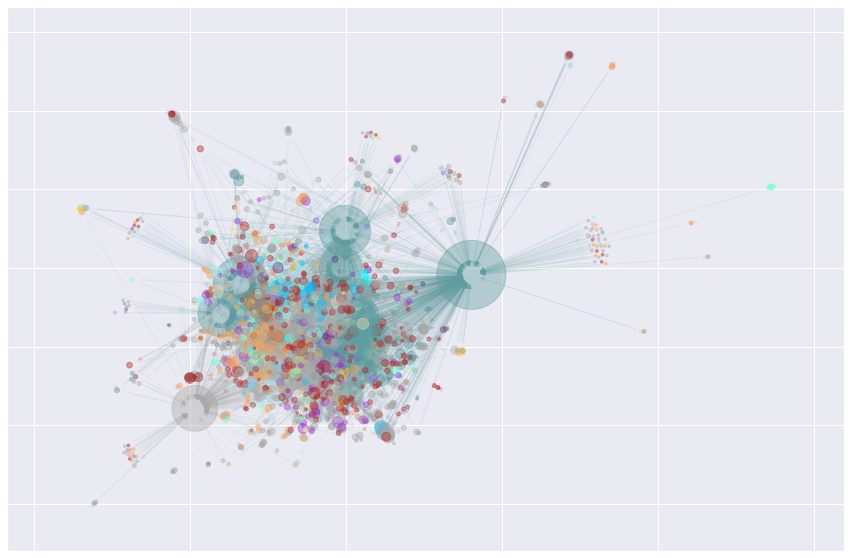

In [19]:
plt.figure(figsize=(15, 10))
_ = nx.draw_networkx_nodes(G, node_pos, nodelist=d.keys(), node_size=node_sizes, alpha=0.4, node_color = node_color)
_ = nx.draw_networkx_edges(G, node_pos, alpha=0.1, edgelist=edges, edge_color=color_list_edge)

The plot is very similiar to the undirected one. As it can be seen then most of the edges has the same color, this is because they are pointing the a node with the category '4.th grader'. This is the category for most of the main characters. 

# Analysis 

To do a proper analysis of the words used on the pages, cleaning of the character pages is needed. There is a lot of brackets containing links or basic stats like age etc. This will have to removed for every single page. This is done by using a number of regex that substitutes it by an empty string. The regex method can be viewed [here](https://github.com/koldbrandt/socialgraphs/blob/main/SP_get_characters.ipynb) in the section "Clean character pages"

## Communities and categories in south park 

To analyse the dataset we will first look into the categories and communities of the dataset. The categories is defined by the wikipage and can be seen in the picture below.

<p align="center">
<img src="Images/Categories.PNG"/>
</p>

The category for each character is listed in the bottom of the character page. The pattern for categries are `[[Category: category name]]` like the list below. 
<pre>
[[Category:Characters]]
[[Category:Political celebrities]]
[[Category:Presidents of the United States]]
[[Category:Male characters]]
[[Category:Adult characters]]
[[Category:Minor characters]]
[[Category:Characters voiced by Matt Stone]]
[[Category:Characters voiced by Kyle McCulloch]]
[[Category:Elderly people]]
</pre>

This gives a regex that looks like the following:  `r'(?<=[[Category:)(.*?)(?=])'`  
This will give a list of all the categories that a character is part of. But this is not the coherent throughout the pages, and so defining categories for each character was cumbersume. Many of the character pages had the same categories such as "Category:Characters voiced by Kyle McCulloch" and this does not make sense to analyse upon, as almost all characters are voiced by the same actors.
Therefor we decided to filter out all categories that are not one of the categories listed in the picture above. The category "School Characters" and "Creatures" were not referenced on a single page, but "Celebrities" was. The idea was to have each character be listed under their subcategory, but as many characters in the celebrity category didn't have a sub category, this idea was dismissed. 

Many of the characters did not have one of the categories listed above, so instead they were assigned as "uncategorized". This means that the largest category group is uncategorized and the plot below shows the distribution. The approach for assigning the categories can be viewed [here](https://github.com/koldbrandt/socialgraphs/blob/main/SP_get_characters.ipynb) under the section **Categories**

In [20]:
df_characters =  pd.read_csv('characters.csv')
df_characters['mainCategories']=df_characters['mainCategories'].apply(literal_eval)

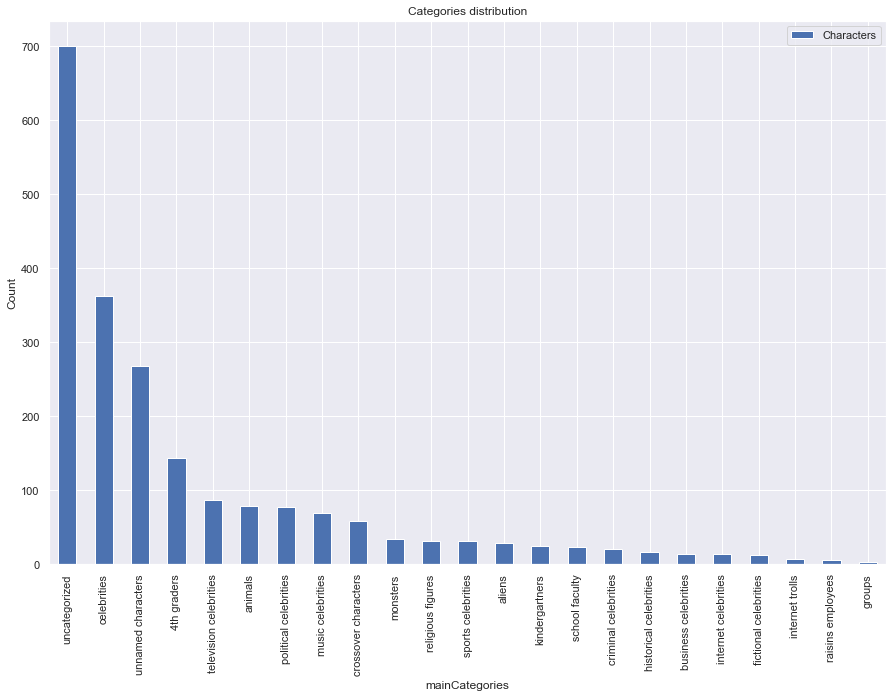

In [21]:
fig, ax=plt.subplots(figsize=(15,10))
df_characters.explode('mainCategories').groupby('mainCategories').agg(count=('Name', 'count')).sort_values(by="count",ascending=False).plot(kind='bar',ax=ax,y='count')
ax.legend(["Characters"])
plt.title("Categories distribution")
plt.ylabel("Count")
plt.savefig('categories.png')
plt.show()

From the above plot, it is clearly visible that half the characters have the "uncategorized" category, and that the largest of the real categories are the celebrities and the 4th graders. This is expected, as the show have used alot of celebrities throughout the seasons, and the 4th graders are the main characters of the show. 

Now the communities of the gcc is found and each community is added to the df_characters and the modularity is calculated

In [22]:
gcc = pickle.load(open("network/SouthParkUnirectedGCC.gpickle", 'rb'))
partition = community_louvain.best_partition(gcc,random_state=42)
#Create dataframe with comuunities
df_partition = pd.DataFrame(partition.values(), index= partition.keys(), columns = ["Community"])
df_partition = df_partition['Community'].astype('Int64')
df_characters = df_characters.set_index("Name").join(df_partition).reset_index()
df_characters = df_characters[df_characters['Community'].notna()]

In [23]:
modularity=community_louvain.modularity(partition,gcc)
print("The modularity of the network is: "+ str(modularity))

The modularity of the network is: 0.44207786895919954


As the modularity is positive, the number of edges within each community are greater than the number of edges would be if the communities were picked at random. The number also suggest that each character within the communities are connected to alot of other characters. Furthermore, the modularity is considered an optimal modularity (Network science, image 9.16). This means that the algorithm has correctly identified each community and their members. 

In [24]:
#defining node color based on communities

categories = list(set(df_characters.Community.values))
num_colors=len(set(categories))
colors=list(mcolors.CSS4_COLORS.keys())
cluster_colors=random.choices(colors, k=num_colors)

color_dict = {}
for i in range(len(categories)):
    color_dict[categories[i]] = cluster_colors[i]

node_color = []
for node in gcc.nodes():
    cat = df_characters[df_characters.Name == node].Community.values[0]
    node_color.append(color_dict[cat])

The plot below shows the gcc network with each node colored corresponding to the community. The plot can be compared to the gcc plot where each node is colored corresponding to their category. The number of characters in each community can also be seen, this is however not easy to interpret, therefor a bar plot with each community size, named after their most connected character, will also be created.

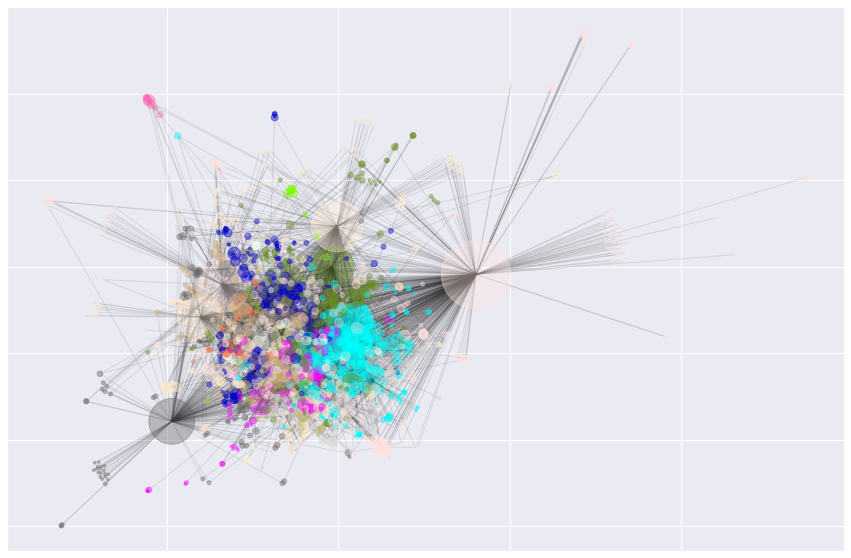

In [25]:
plt.figure(figsize=(15, 10))
_ = nx.draw_networkx_nodes(gcc, node_pos, nodelist=d.keys(), node_size=node_sizes, alpha=0.4, node_color = node_color)
_ = nx.draw_networkx_edges(gcc, node_pos, alpha=0.1)
plt.show()

In [26]:
# getting each community and its members, and storing it as a dict
community_dict={}
for i,j in partition.items():
    community_dict.setdefault(j,[]).append(i)

In [27]:
#Naming each community after their most connected character
communities=list(community_dict.values())
num_edges = {}
for i in range(len(communities)):
    edge_list = []
    for node in communities[i]:
        edge_list.append((node,len(gcc.edges(node))))
    num_edges[i] = sorted(edge_list, key = lambda tup : tup[1], reverse = True)
community_dict = {}
for j in range(len(communities)):
    name = ' '.join([x for x,y in num_edges[j][:1]])
    community_dict[name] = communities[j]

In [28]:
#Sorting so the largest community is the first 
community_dict=dict(sorted(community_dict.items(),reverse=True, key=lambda item: len(item[1])))

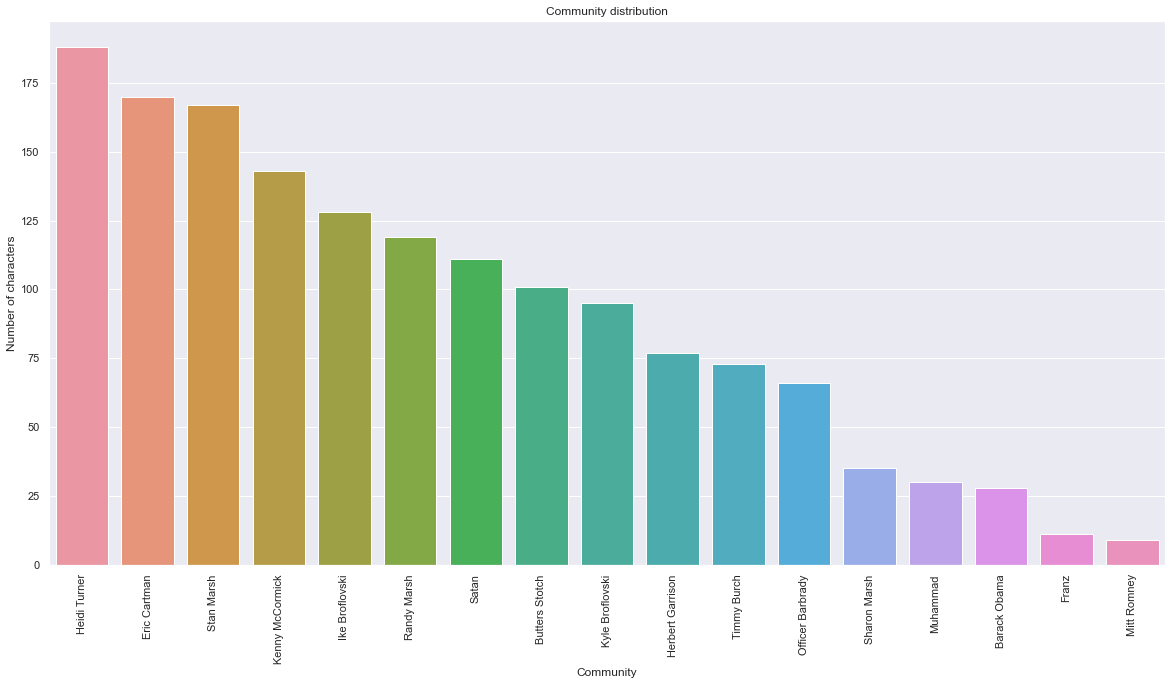

In [29]:
fig, ax = plt.subplots(figsize=(20,10))
x=[x for x in community_dict.keys()]
y=[len(y) for y in community_dict.values()]
all_plot = sns.barplot(x=x, y=y, ax=ax)
plt.xticks(rotation=90)
plt.xlabel("Community")
plt.ylabel("Number of characters")
plt.title("Community distribution")
plt.savefig("CommunityBarPlot")
plt.show()

From the above plot it is clearly visible that the "Heidi Turner" community is the largest, and that generally the communities are quite large. It can also be seen that the four main characters each are the main character of a community, meaning that they are the most connected character within that community. We can now investigate which category is the most common within each community.

In [30]:
def to_1D(df):
    return pd.Series([x for _list in df for x in _list])

In [31]:
for i in range(16):
    temp=list(to_1D(df_characters[df_characters["Community"]==i]["mainCategories"]))
    print("Community " + list(community_dict.keys())[i] + ": "+ max(set(temp), key = temp.count))

Community Heidi Turner: uncategorized
Community Eric Cartman: uncategorized
Community Stan Marsh: celebrities
Community Kenny McCormick: uncategorized
Community Ike Broflovski: uncategorized
Community Randy Marsh: uncategorized
Community Satan: uncategorized
Community Butters Stotch: uncategorized
Community Kyle Broflovski: uncategorized
Community Herbert Garrison: uncategorized
Community Timmy Burch: uncategorized
Community Officer Barbrady: uncategorized
Community Sharon Marsh: celebrities
Community Muhammad: 4th graders
Community Barack Obama: uncategorized
Community Franz: uncategorized


Clearly almost every community will have the uncategorized category as their most commmon category. This makes sense as uncategorized was by far the largest category, as described at the start of the section. The few communities where the most common category is not uncategorized, have the two other largest categories, celebrities and 4th graders. The Stan Marsh community has many celebrities, meaning that stan and his community mainly consists of celebrities. 

As the above list does not give a detailed overview of the most common categories, so the most common categories are removed below (unless the community only contains one of the three categories)

In [32]:
mostCategories =["uncategorized","unnamed characters","celebrities"]
print("Most common category for each community:")
for i in range(16):
    temp=list(to_1D(df_characters[df_characters["Community"]==i]["mainCategories"]))
    if len(temp)>15:
        temp=[x for x in temp if x not in mostCategories]
    print("Community " + list(community_dict.keys())[i] + ": "+ max(set(temp), key = temp.count))

Most common category for each community:
Community Heidi Turner: crossover characters
Community Eric Cartman: 4th graders
Community Stan Marsh: political celebrities
Community Kenny McCormick: television celebrities
Community Ike Broflovski: television celebrities
Community Randy Marsh: crossover characters
Community Satan: kindergartners
Community Butters Stotch: 4th graders
Community Kyle Broflovski: music celebrities
Community Herbert Garrison: television celebrities
Community Timmy Burch: animals
Community Officer Barbrady: political celebrities
Community Sharon Marsh: political celebrities
Community Muhammad: 4th graders
Community Barack Obama: uncategorized
Community Franz: television celebrities


Most of the communities still have celebrities as the most common members, and interesstingly, the four main characters each have a different category within their communities. It is also worth to note that the main category in the satan community is the kindergarterners (evil little pricks).

## Term Frequency TF

Now the tf and tf-idf can be calculated. First all the clean pages are downloaded and put together in a dictionary, where each key in the dictionary is the name of the of the most connected character in the Community, and the values are the texts of all the characters in the community. Some characters does not have a community, and therefor every character without a community is dropped for this part. This does not have a big effect, as characters that are not a part of a community typically wont have a big impact on the network. 

In [33]:
#function to get the cleaned pages and join the pages in one long string
def get_lemmatized_text(charlist):
    data=""
    for i in charlist:
        with open('southpark_pages_clean/' + i.replace("\"", "") + ".txt", 'r', encoding='utf-8' ) as file:
            data += file.read()
    tk = WordPunctTokenizer()
    lemmatizer = WordNetLemmatizer()
    text_tokenized = tk.tokenize(data)
    blacklist = stopwords.words()
    text_lemmatized = [lemmatizer.lemmatize(w.lower()) for w in text_tokenized if w.lower() not in blacklist]
    return text_lemmatized

In [34]:
communityFiles = {}
for i in df_characters.Community.dropna().unique():
    temp = []
    for x in df_characters[df_characters.Community == i].Name:
        temp.append(x)
    communityFiles[i] = temp

In [35]:
communityText = {}
for i in df_characters.Community.dropna().unique():
    communityText[i] = get_lemmatized_text(communityFiles[i])
communityText=dict(zip(list(community_dict.keys()),list(communityText.values()))) 

The Term Frequency or TF is calculated by counting the number of times a given term appears in a text, and then dividing by the length of the text. Then the terms are sorted with the most frequent appearing first. This gives a list of the most used words in a dataset, which are often the words that describe the dataset the best.

In [36]:
#Function to calculate TF
def tf(inputtext):
    words = nltk.Text(inputtext)
    fdist1 = nltk.FreqDist(words)
    length = len(inputtext)
    tf = [(word, round(freq/length,4)) for word, freq in fdist1.items()]
    text = sorted(tf, key=lambda tup: tup[1], reverse=True)
    return text[:5]

In [37]:
#top 5 words for each community according to tf
for i in list(communityText.keys()):
    print("Community "+str(i)+": "+str(tf(communityText[i])))

Community Heidi Turner: [('timmy', 0.0088), ('hair', 0.0078), ('jimbo', 0.0072), ('character', 0.007), ('appearance', 0.0068)]
Community Eric Cartman: [('kenny', 0.0138), ('black', 0.0083), ('cartman', 0.0075), ('hair', 0.0069), ('appearance', 0.0055)]
Community Stan Marsh: [('stan', 0.0159), ('hair', 0.0089), ('appearance', 0.0087), ('character', 0.0075), ('wear', 0.0065)]
Community Kenny McCormick: [('randy', 0.0158), ('black', 0.0109), ('character', 0.0097), ('hair', 0.0095), ('brown', 0.0092)]
Community Ike Broflovski: [('cartman', 0.0133), ('school', 0.0128), ('boy', 0.0085), ('kid', 0.0077), ('girl', 0.0076)]
Community Randy Marsh: [('mr', 0.0183), ('garrison', 0.0151), ('hair', 0.0078), ('crab', 0.007), ('appearance', 0.0069)]
Community Satan: [('grader', 0.0171), ('th', 0.015), ('boy', 0.0104), ('randy', 0.0098), ('sharon', 0.0093)]
Community Butters Stotch: [('hair', 0.0102), ('ike', 0.01), ('black', 0.0076), ('appearance', 0.0076), ('wear', 0.0076)]
Community Kyle Broflovski:

The term frequency for each community makes it clear that the most used words on the character pages are descriptive words or references to main characters, such as Cartman. The words appearance and hair, are used alot in all communities, as these words are used to describe the characters on their pages. This approach gives a good idea about the content of the pages and what words the authors use to describe the characters

## TF-IDF

The purpose of tf-idf is to find out how relevant a word is in a document, depending on the number of documents. The tf-idf is calculated by multiplying how many times a word appears in a document ie. TF, and the inverse of how many times it occurs in a document, meaning the more documents that contain the word, the less important the word is. Therefor it is expected that the tf-idf words will be different from the tf words that was found above.

The reason for using the log in the idf calculation is, if the number of documents is very large, and the word count is very low, the tf-idf score wont be massively large.
The tf idf scores are added to the communityText dict, as new keys with each word as values with their corresponding tf-idf score

In [38]:
#making one long text
text=[item for sublist in list(communityText.values()) for item in sublist]
text = nltk.Text(text)
fdist = FreqDist(text)

In [39]:
num_doc=len(list(communityText.keys()))
idf_dic =  {}
for i in set(text):
    t_in_doc = 0
    for j in list(communityText.keys()):
        if i in communityText[j]:
            t_in_doc += 1
        idf_dic[i] = log(num_doc/(t_in_doc+1))

for k in list(communityText.keys()):
    words = nltk.Text(communityText[k])
    fdist1 = nltk.FreqDist(words)
    length = len(communityText[k])
    tfidf = [(word, round(idf_dic[word]*(freq/length),4))for word, freq in fdist1.items()]
    communityText[k+ ' tfidf'] = sorted(tfidf, key=lambda tup: tup[1], reverse=True)

In [40]:
#tf-idf for all communities
for i in list(communityText.keys())[0:17]:
    print("Community " + i + ": "+str((communityText)[i +' tfidf'][:5]))

Community Heidi Turner: [('nathan', 0.006), ('mimsy', 0.0055), ('scuzzlebutt', 0.0055), ('timmy', 0.0047), ('jimbo', 0.0046)]
Community Eric Cartman: [('mysterion', 0.0041), ('stuart', 0.004), ('coon', 0.0034), ('henrietta', 0.0029), ('spielberg', 0.0025)]
Community Stan Marsh: [('pope', 0.0049), ('sy', 0.0024), ('shelly', 0.0021), ('maxi', 0.002), ('tad', 0.0019)]
Community Kenny McCormick: [('mickey', 0.0044), ('haha', 0.0025), ('marvel', 0.0024), ('pangolin', 0.0023), ('randy', 0.002)]
Community Ike Broflovski: [('heidi', 0.0058), ('hallway', 0.0028), ('clyde', 0.0024), ('token', 0.0023), ('pip', 0.0023)]
Community Randy Marsh: [('crab', 0.0121), ('clark', 0.0044), ('garrison', 0.0029), ('sophie', 0.0029), ('scott', 0.0019)]
Community Satan: [('grader', 0.006), ('sharon', 0.0049), ('trent', 0.0042), ('hirohito', 0.0031), ('ose', 0.0031)]
Community Butters Stotch: [('ike', 0.0053), ('troll', 0.0052), ('gerald', 0.0035), ('filmore', 0.0031), ('kindergarten', 0.0019)]
Community Kyle Br

This gives a nice overview of what terms are most relevant to each community. As an example, the Mitt Romney community clearly contains pages where Barack Obama is mentioned alot. 

We can also analyse the pages by looking at the most used words from the joined text of the pages.

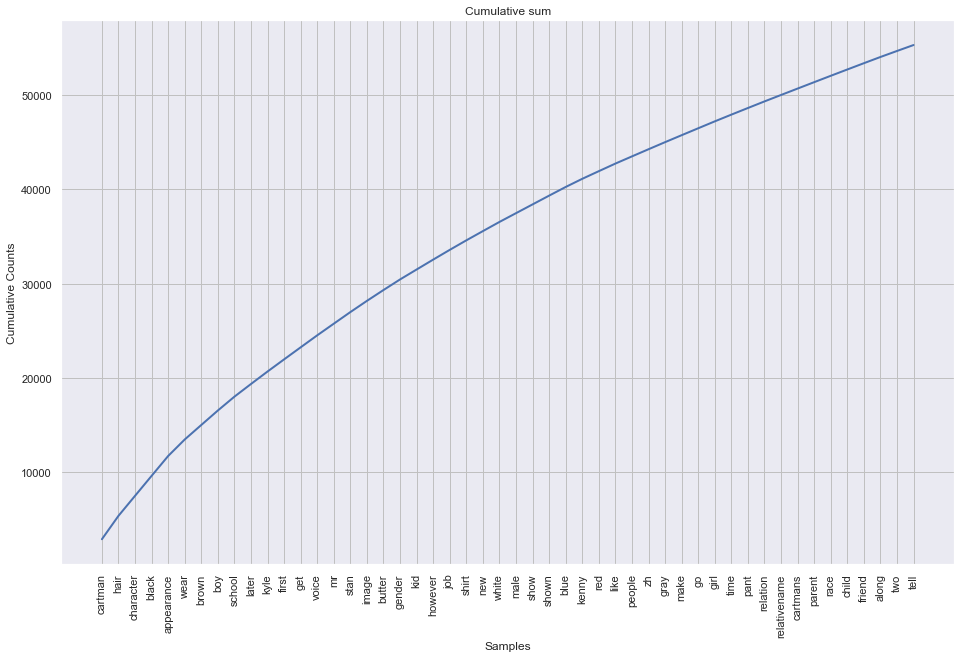

<AxesSubplot:title={'center':'Cumulative sum'}, xlabel='Samples', ylabel='Cumulative Counts'>

In [41]:
#cumulative distribution plot of 75 most used words
plt.figure(figsize=(16, 10))
plt.savefig("wordsSum")
fdist.plot(50, cumulative=True,title="Cumulative sum")


Furthermore, we check if Zipf's law is applicable on the dataset. Zipf's law states that the most used word is used twice as must as the second most used word, and so forth. We compare this with the plot of a random list of words. The random list of words are generated using the random package, and the amount of words are the same as in the South Park dataset.

In [42]:
#function calculate zipfs law
def zipfs(text):
    temp={}
    for word in text:
        count = temp.get(word,0)
        temp[word] = count + 1
    temp={k: v for k, v in sorted(temp.items(), key=lambda item: item[1], reverse=True)}
    return temp

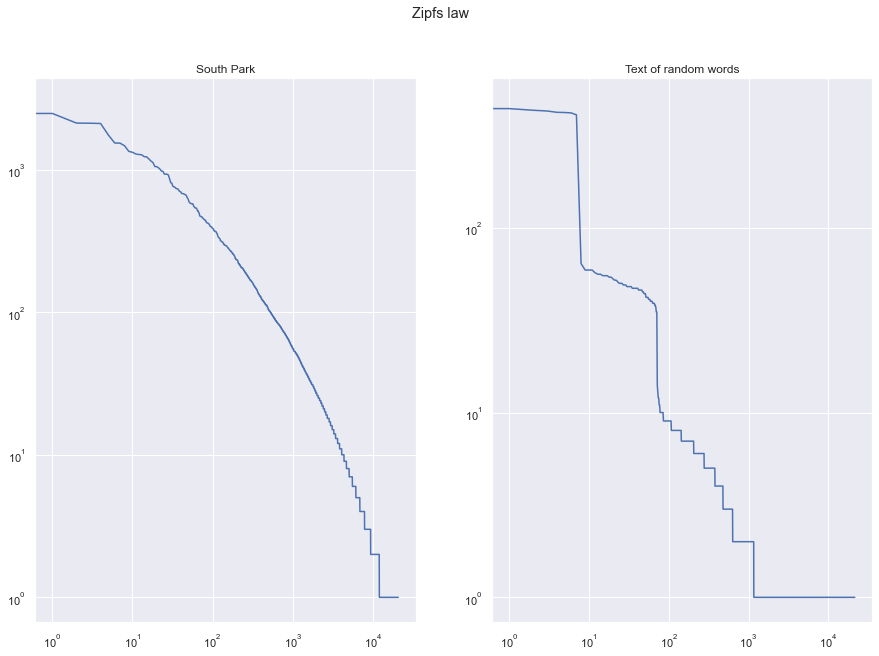

In [45]:
result=zipfs(text)
x=list(result.keys())
y=list(result.values())

randomText=""
for i in range(len(text)):
    randomText+= random.choice("abcdefgh ")
randomText=nltk.word_tokenize(randomText)
resultRandomText=zipfs(randomText)
xRandom=list(resultRandomText.keys())
yRandom=list(resultRandomText.values())

fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.suptitle('Zipfs law')
axs[0].loglog(y)
axs[0].set_title("South Park")
axs[1].loglog(yRandom)
axs[1].set_title("Text of random words")
plt.savefig("Zipfslaw")
plt.show()

From the above plots it can be concluded that the southpark text is indeed in line with Zipfs law, but it does have a higher number of words that are used alot. Below is the print of the five most used words, and it can be seen that the most used word is not twice as used, as the second most used word. But as the frequency of words lower, zipfs law fits better and better on the dataset. The most used word is Cartman, which must mean that alot of the pages references Cartmann. This supports the results found in the basic stats section, that found Cartman to be the most connected character. The second most used word is hair, and the third most is character. The reason for this is that almost every page uses these words to describe the given character, which is the reason that Zipf's law does not hold for the most used words. 


Zipf's law will also be calculated for the episodes dialogue.

In [46]:
# 5 most used words of the pages
print(list(result.items())[:5])

[('cartman', 2927), ('hair', 2478), ('character', 2121), ('black', 2116), ('appearance', 2107)]


## Sentiment Analysis of Character Pages

To analyse the sentiment of the character pages, both the vader lexicon and the labMT scores are used. The presumption is that the results of the two different methods will differentiate alot. This is due to the fact that one is a rule based method, and one is a dictionary based method. The idea behind using this analysis is to get an understanding of the rethoric used on each character page. 
Firstly, sid and lambt sentiment analyzers are loaded and the list of characters is defined. 

In [47]:
sid = SentimentIntensityAnalyzer()
df_lambt=pd.read_csv("labmt.txt",delimiter="\t")
characters = list(df_characters.Name)

Every text is added to a dict, where the keys are the character names, and the values are the character texts. Stopwords are removed and the text is lemmatized.

In [48]:
charactersText ={}
for i in characters:
    with open('southpark_pages_clean/' + i.replace("\"", "") + ".txt", 'r', encoding='utf-8' ) as file:
        data = file.read()
    tk = WordPunctTokenizer()
    lemmatizer = WordNetLemmatizer()
    text_tokenized = tk.tokenize(data)
    blacklist = stopwords.words()
    text_lemmatized = [lemmatizer.lemmatize(w.lower()) for w in text_tokenized if w.lower() not in blacklist]
    charactersText[i] = text_lemmatized

The Vader score is calculated for each character and stored in a dict. Then lists are created for each score and we can look at the most negative/postive character from the wiki pages. The compound describes how negative/positive/neutral a character is. A compound below -0.05 is considered negative and above 0.05 is considered positive, leaving neutral in between the two.

In [49]:
scores = {}
for i in characters:
        loaded_text = charactersText[i]
        scores[i]=sid.polarity_scores(' '.join(loaded_text))

In [50]:
neg = [scores[i]['neg'] for i in characters]
pos = [scores[i]['pos'] for i in characters]
neu = [scores[i]['neu'] for i in characters]
compound = [scores[i]['compound'] for i in characters]
def vaderScore(score):
    tup=()
    count=0
    vaderList=[]
    for i in characters:
        tup=(i,score[count])
        vaderList.append(tup)
        count +=1
    return sorted(vaderList, key=lambda tup: tup[1], reverse=True)

Printing the compound for the 10 characters with the highest compound score, and with the lowest compound score

In [51]:
highest = "".join([char + " : " + str(score) +  '\n' for char,score in vaderScore(compound)[:10]])
lowest = "".join([char + " : " + str(score) +  '\n' for char,score in vaderScore(compound)[-10:]])
print("Highest ranking characters according to Vader Compound score")
print(highest)
print("Lowest ranking characters according to Vader Compound score")
print(lowest)

Highest ranking characters according to Vader Compound score
Douchebag : 0.9998
Jimmy Valmer : 0.9988
Timmy Burch : 0.9974
Nichole Daniels : 0.9965
Seaman : 0.9948
Jesus Christ : 0.9943
Girl with Blonde Hair : 0.9942
Stephen Abootman : 0.9939
Maggie Yates : 0.9935
Lola : 0.9932

Lowest ranking characters according to Vader Compound score
Herbert Garrison : -0.9996
Principal Victoria : -0.9996
Nathan : -0.9997
Saddam Hussein : -0.9997
Stan Marsh : -0.9999
Heidi Turner : -0.9999
Randy Marsh : -0.9999
Butters Stotch : -0.9999
Kenny McCormick : -1.0
Eric Cartman : -1.0



Interesstingly, the main characters have the lowest compound score, and are thus the characters described in the most negative way according to vader. The happiest guy is douchebag which makes a lot of sense since he is always happy in the episodes, and he is "new" to South park. 

To get a better understanding the Vader scores can be plotted using histograms.

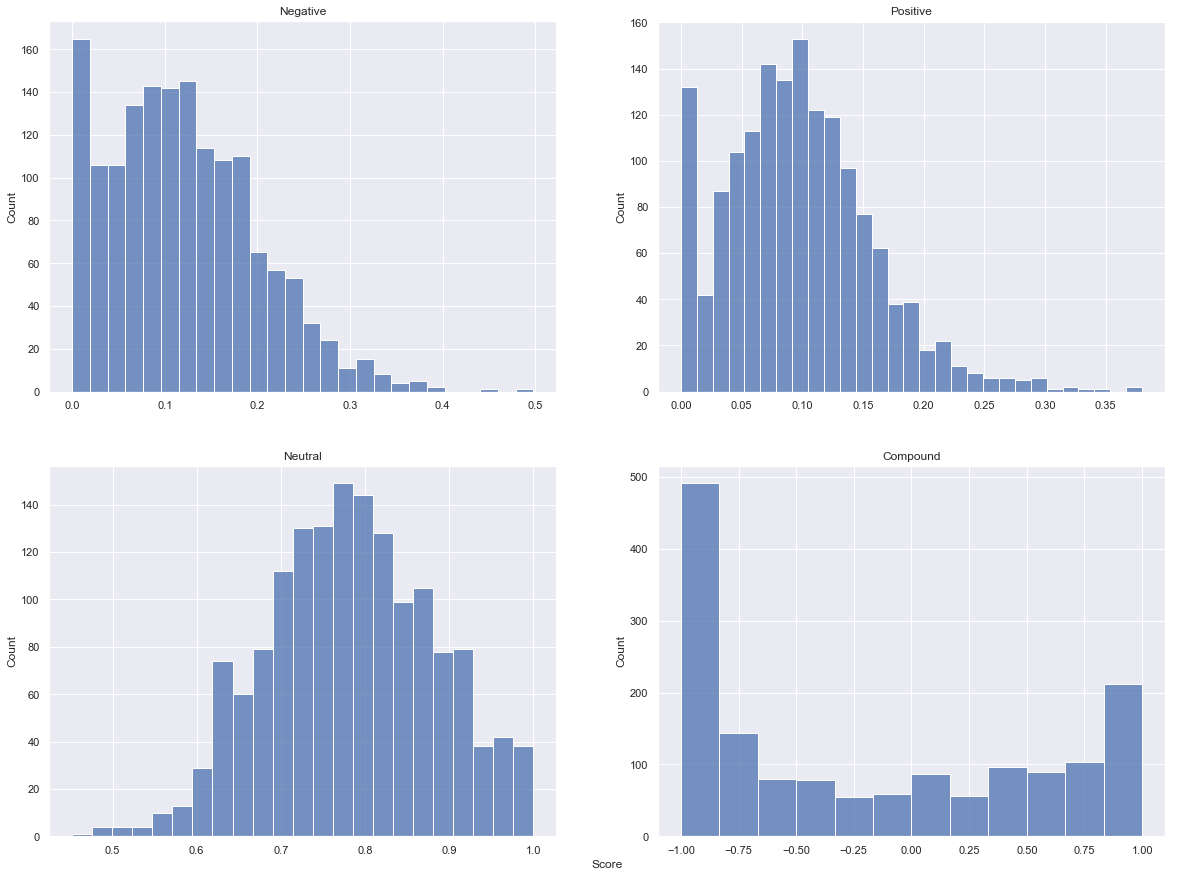

In [52]:
fig, axes =plt.subplots(2,2,figsize=(20,15))
sns.histplot(ax = axes[0,0], x=neg)
sns.histplot(ax = axes[0,1], x=pos)
sns.histplot(ax = axes[1,0], x=neu)
sns.histplot(ax = axes[1,1], x=compound)
fig.add_subplot(111, frameon=False)
axes[0,0].set_title("Negative")
axes[0,1].set_title("Positive")
axes[1,0].set_title("Neutral")
axes[1,1].set_title("Compound")
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Score")
plt.show()

So from the compound plot, it can be seen that most of the characters are described in a very negative way. The positive and negative score are quite 

To compare, the sentiment is also calculated from the LabMT sentiment analyser. To do this the same course of action is used, a dict is created to store the lambt score of each character 

In [53]:
labmt_score = {}
for k in characters:
    loaded_text = charactersText[k]
    fdist = nltk.FreqDist(loaded_text)
    count = 0
    for i,j in fdist.items():
        if i.lower() in df_lambt.word.values:
            count += df_lambt[df_lambt.word == i.lower()].happiness_average.values[0]*j/len(loaded_text)
    labmt_score[k] = (count)

In [54]:
# sorting the scores
sortedkeys = sorted(labmt_score, key = labmt_score.get, reverse=True)

In [55]:
#lambt highest and lowest happiness scores
highest = "".join([char + " : " + str(labmt_score[char]) +  '\n' for char in sortedkeys[:10]])
lowest = "".join([char + " : " + str(labmt_score[char]) +  '\n' for char in sortedkeys[-10:]])
print("Highest ranking characters according to labMT")
print(highest)
print("Lowest ranking characters according to labMT")
print(lowest)

Highest ranking characters according to labMT
Mary, Mother of Jesus : 5.975714285714285
Ugly Girl (Probably) : 5.727906976744186
Charlotte's Mother : 5.692500000000001
Canadian Gift Shop Owner : 5.633076923076923
Spinny Mountain Records Producer : 5.633030303030303
Mr. Allen : 5.454408602150538
Girl with Pink Coat : 5.419555555555554
Jeffy's Farmer : 5.403384615384618
6th Grader Girl with Blonde Hair : 5.399310344827586
Vegan Boy : 5.392833333333332

Lowest ranking characters according to labMT
Feldspar the Thief : 3.170144927536231
Vaping Man : 3.1664285714285714
Marty : 3.118888888888889
John Wilkes Booth : 3.0538709677419362
Predator : 3.043571428571428
Clone Stan Marsh : 3.007912087912088
Tinkerbell : 3.0028571428571427
Ranger McFriendly : 2.888297872340425
Fifi : 2.849375
Rex : 2.204444444444445



The most positive is Mary, the mother of jesus, which makes good sense since she is considered by millions to be the holiest and greatest saint. She also plays a very small part in the series, which is also the case with the rest of the characters. All of the characters with the happiest and saddest pages according to labMT has very limited text in their pages, and therefor only a few words is used to calculate the labMT score. 

In conclusion the best analysis of this dataset is carried out by looking at the vader score instead of the labMT score. Below the Vader positive result, and the labMT scores are plotted next to each other. Interestingly, the labMT actually looks like a normal distribution, whereas the vader is rather right skewed. From this we can conclude that vader generally interprets the text in a negative way and that labMT scores the text as almost neutral. 

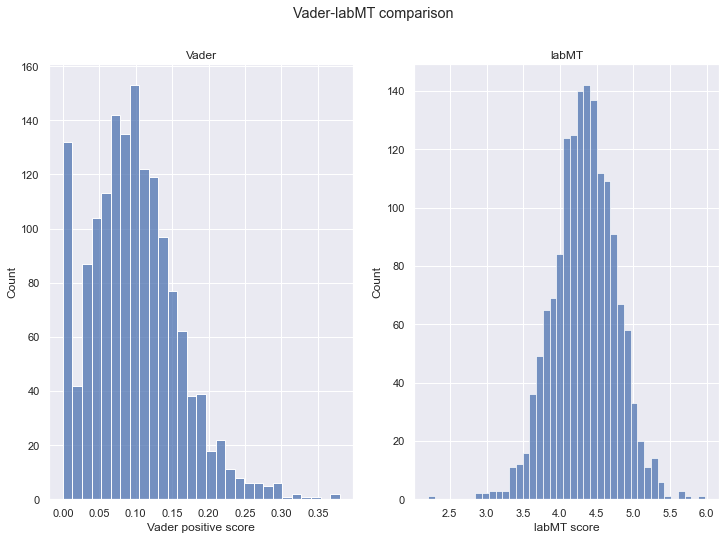

In [56]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,8))
fig.suptitle('Vader-labMT comparison')
sns.histplot(ax = ax1, x=pos)
ax1.set_xlabel('Vader positive score')
ax1.set_title("Vader")
sns.histplot(ax = ax2, x=list(labmt_score.values()))
ax2.set_xlabel('labMT score')
ax2.set_title("labMT")
plt.show()

## Episodes analysis

The tv show has run for many years and therefore is an interesting thing to try to find some insights which we can reach from episodes’ data. On the South Park wiki page we can find a section called “Episodes”, which contains information about all episodes (seasons and special episodes). In this case we will take a look only on episodes from regular seasons, since it allows us to compare how South Park has changed over the years. 

### Getting the data and cleaning

First to start analysing South Park episodes we need to get data about them. Looking at the episodes section on the fandom wiki page we can notice that episodes are splitted into the seasons and stored in the form of tables (separate table for each season). Table form of data allowed us to use `Padnas` function `read_html` which read all HTML tables from a particular page into a list of data frames. From the received list we took only data frames which correspond to South Park seasons. The selected frames started to be clean first by removing the first column which contains only nan values and by setting the first row as column names. The frames obtained in this way had the data rows alternated. The first row contained data about an episode (title, air date, code and episode number) and the following row contained a description of the episode in each column. Only rows which contained information about episodes were selected and corresponding to their descriptions were added into a new column. At this stage our data frame had 5 columns:
- Title: episode title
- Air Date: release date
- Code: code with season and episode number 
- #: episode number in total
- Descriptions: description of episode

Our next step was to add data about characters that take a part in episodes. Looking at the pages of particular episodes we can see that the cast of each episode is listed in section “Cast” on the “Script” subpage. In the source code of pages each element of this list has an argument `title` containing the name of the character. We used the function `get` from the `request` package to download pages’ source code and regular expression to find all matching elements. The regular expression looks like the following:  `title="[\[[a-zA-Z0-9\'\\ -.]*`
From received strings we extracted the name of characters by removing unnecessary parts of the strings like `title=”`. Characters obtained in this way are compared with a list of all characters which were prepared in previous parts, and filter out only those characters which were in it. This list of characters from each episode was added to the “Cast” column in our frame. At the end we added the column “Seasons” with the numbers of seasons from which episodes were. Data were saved into episodes.csv and can be find [here](https://github.com/koldbrandt/socialgraphs/blob/episodes-analysis/episodes.csv).

*Data for the episode with code 1414 was downloaded and added to the data frame manually to issues with encoding of episode title. 

In [4]:
# Load dataset with episodes informations
df_episodes = pd.read_csv('episodes.csv', index_col=0)

In [5]:
df_episodes.head(10)

Title            Air Date  Code   #  \
0       Cartman Gets an Anal Probe     August 13, 1997   101   1   
1                 Weight Gain 4000     August 20, 1997   102   2   
2                          Volcano     August 27, 1997   103   3   
3   Big Gay Al's Big Gay Boat Ride   September 3, 1997   104   4   
4  An Elephant Makes Love to a Pig  September 10, 1997   105   5   
5                            Death  September 17, 1997   106   6   
6                          Pinkeye    October 29, 1997   107   7   
7                  Starvin' Marvin   November 19, 1997   109   8   
8    Mr. Hankey, the Christmas Poo   December 17, 1997   110   9   
9                           Damien    February 4, 1998   108  10   

                                        Descriptions  \
0  While the boys are waiting for the school bus,...   
1  When Cartman's environmental essay wins a nati...   
2  A weekend trip to experience the finer points ...   
3  When Stan discovers his new dog Sparky is gay,...   
4  Kyle's mom won't let him keep his new pet, an ...   
5  Grandpa's sole birthday wish is for Stan to ta...   
6  A mishap at the morgue transforms the resident...   
7  Mistaking Cartman for a starving African child...   
8  While South Park Elementary is attempting to s...   
9  After being shunned by the others kids, Damien...   

                                                Cast  Season  
0  ['Pip Pirrip', 'Liane Cartman', 'Jerome "Chef"...       1  
1  ['Officer Barbrady', 'Stan Marsh', 'Wendy Test...       1  
2  ['Ted', 'Liane Cartman', 'Randy Marsh', 'Jerom...       1  
3  ['Jesus Christ', 'Frank Hammond and Phil', 'St...       1  
4  ['Jesus Christ', 'Officer Barbrady', 'Sharon M...       1  
5  ['Jesus Christ', 'Sheila Broflovski', 'Officer...       1  
6  ['Officer Barbrady', 'Stan Marsh', 'Midget Wea...       1  
7  ['Officer Barbrady', 'Stan Marsh', 'Wendy Test...       1  
8  ['Jesus Christ', 'Mr. Hankey', 'Sheila Broflov...       1  
9  ['Jesus Christ', 'Stan Marsh', 'Wendy Testabur...       1

Scripts of episodes can be found on subpage “Scripts”  of their wiki fandom page. They are stored in the form of an HTML table with 2 columns. First contains character names and second dialogues. Similar as it was with the episodes data frame we use `Pandas read_HTML` to read scripts for all episodes. From downloaded scripts we dropped all scenario descriptions (rows which had Nan in the character name column). Next, from dialogues text we removed description of the activities and situations in which they were said (text between [...]). We removed it using the function re.sub and the following regular expression: `[\[].*?[\]]`. Also we removed all ‘(‘ and ‘)’ between which were placed Kenny's dialogues and lines which were thoughts (we assumed that we would treat them like normal dialogues). At the end we added columns “Code” and “Season” with information about episode and season number. Obtained tables with scripts were concat into one and saved into a lines.csv file. This file can be find [here](https://github.com/koldbrandt/socialgraphs/blob/episodes-analysis/lines.csv)

*Data for the episode with code 1414 was downloaded and added to the data frame manually to issues with encoding of episode title.

In [6]:
# Load dataset with episodes scripts
df_lines = pd.read_csv('lines.csv')

In [7]:
df_lines.head(10)

Character                                              Lines  \
0         The boys   School days, school days, teacher's golden ru...   
1  Kyle Broflovski  Ah, damn it! My little brother's trying to fol...   
2   Ike Broflovski                                        Eat banana.   
3             Kyle  Ike, you can't come to school with me. [Ike Ch...   
4     Eric Cartman                    Yeah, go home you little dildo!   
5             Kyle               Dude, don't call my brother a dildo!   
6       Stan Marsh                                    What's a dildo?   
7             Kyle  Well, I don't know...[He faces Cartman and poi...   
8          Cartman                              I know what it means!   
9             Kyle                                        Well, what?   

                                         Lines_clean  Code  Season  
0    School days, school days, teachers golden ru...   101       1  
1  Ah, damn it! My little brothers trying to foll...   101       1  
2                                        Eat banana.   101       1  
3             Ike, you cant come to school with me.    101       1  
4                    Yeah, go home you little dildo!   101       1  
5                Dude, dont call my brother a dildo!   101       1  
6                                     Whats a dildo?   101       1  
7  Well, I dont know... and Ill bet Cartman doesn...   101       1  
8                              I know what it means!   101       1  
9                                        Well, what?   101       1

To see how all episodes data and scripts has been download look [here](https://github.com/koldbrandt/socialgraphs/blob/update-notebook/Episodes_data.ipynb).

### Network of characters

First we decided to investigate relations between characters in the episodes. For this purpose we created a graph of characters in the episodes. Similar as it was with previous graphs we used “characters.csv” to create nodes corresponding to series characters. Two nodes were linked when 2 characters took part at least in one episode together. To get a list of edges between nodes we used data about cast in each episode and function `combinations` from `itertools` package. This function returns all n-element combinations in a given list. In our case n was equal 2 and our list was a list of characters  from a particular episode (“Cast”). All edges were added to the graph. For further analysis we extracted gcc (only characters which appeared at least in one episode) from the graph and saved it into a pickle file. File with network can be find [here](https://github.com/koldbrandt/socialgraphs/blob/episodes-analysis/network/SouthParkEpisodesNetwork.gpickle).

Loading gcc with charaters in episodes:

In [42]:
gcc = nx.read_gpickle('network/SouthParkEpisodesNetwork.gpickle')

We will start with showing some stats on the network. Here are number of nodes, edges and a list of the 5 most connected characters.

In [43]:
printBasicStatsUD(gcc)

Basic stats for the gcc network:
Number of nodes:  1171
Number of edges:  22476
Average degree:  38.38770281810419
Average distance between 2 nodes:  1.9369853242903226

5 most connected characters: 
Kenny McCormick: 1170 edges
Eric Cartman: 1170 edges
Stan Marsh: 1135 edges
Kyle Broflovski: 1132 edges
Butters Stotch: 859 edges


When we compare the number of nodes in this network to the number of nodes in previous networks, it can be noticed that there are less nodes. This difference is due to the fact that not all characters mentioned on characters wiki fandom page took part in episodes from regular seasons. Some of them are characters from movies, games or special episodes.
When it comes to the number of edges there are many more in comparison to previous networks. 

When looking at the 5 most connected characters, we have 4 main South Park characters in 4 first places. 5th the most connected character is Butters Stotch who is considered to be one of the major characters too. Based on results we can assume that this is due to the fact how often he appears in episodes.

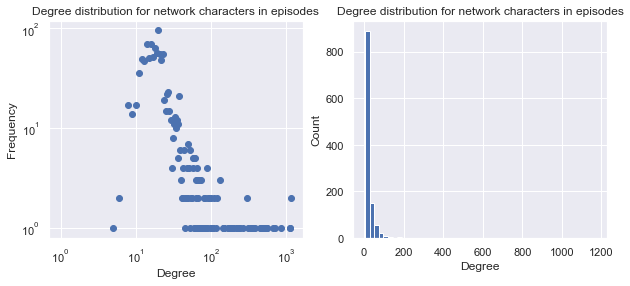

In [44]:
f, ax = plt.subplots(1, 2, figsize=(10, 4))
degree_freq = nx.degree_histogram(gcc)
degrees = range(len(degree_freq))
ax[0].loglog(degrees, degree_freq,'o') 
ax[0].set_xlabel('Degree')
ax[0].set_ylabel('Frequency')
ax[0].set_title("Degree distribution for network characters in episodes")
degrees = [val for (node, val) in gcc.degree()]
d1 = np.array(degrees)
ax[1].hist(d1, bins = 50) 
ax[1].set_xlabel('Degree')
ax[1].set_ylabel('Count')
_= ax[1].set_title("Degree distribution for network characters in episodes")

The degree distribution tells us that the network is not random. This is expected since we have some characters that appear in most of the episodes and a lot of characters that only show in a single episode or a few. This gives a very uneven distribution through the network. In the network there are no nodes with degree equal to 0 because during all seasons there was no episode in which only one character appeared. 

Now we can plot the network using forceatlas2. The nodes will be colored in regards to their category and the size of nodes will be found from its degree.

setting node size depending on degree

In [45]:
d_gcc = dict(gcc.degree)
node_sizes = [2*v for v in d_gcc.values()]

Loading in the csv files with all characters and their category

In [46]:
df_characters =  pd.read_csv('characters.csv')

Making a list of colors for each edge. This is done by making a dictionary where key is category and value is a color. Then mapping each node together with a color depending on its category.

In [47]:
categories = list(set(df_characters.subCategory1.values))
num_colors=len(set(categories))
colors=list(mcolors.CSS4_COLORS.keys())
cluster_colors=random.choices(colors, k=num_colors)

color_dict = {}
for i in range(len(categories)):
    color_dict[categories[i]] = cluster_colors[i]

node_color = []
for node in gcc.nodes():
    cat = df_characters[df_characters.Name == node].subCategory1.values[0]
    node_color.append(color_dict[cat])

In [48]:
color_dict

{'unnamed characters': 'blanchedalmond',
 'television celebrities': 'green',
 'crossover characters': 'yellow',
 'historical celebrities': 'lightgoldenrodyellow',
 'celebrities': 'goldenrod',
 'school faculty': 'ivory',
 'raisins employees': 'olivedrab',
 'internet celebrities': 'violet',
 'aliens': 'mediumpurple',
 'uncategorized': 'navajowhite',
 'internet trolls': 'yellowgreen',
 'kindergartners': 'lightslategrey',
 'monsters': 'cyan',
 'music celebrities': 'indigo',
 'animals': 'darkmagenta',
 'business celebrities': 'honeydew',
 'political celebrities': 'lightblue',
 '4th graders': 'olivedrab',
 'criminal celebrities': 'blanchedalmond',
 'religious figures': 'wheat',
 'fictional celebrities': 'teal'}

It can now be plottet using forceatlas 2

In [ ]:
# compute node positions with the fa algorithm
node_pos_gcc = forceatlas2.forceatlas2_networkx_layout(gcc, pos=None, iterations=2000)

 32%|███▏      | 641/2000 [00:04<00:10, 131.44it/s]

In [ ]:
plt.figure(figsize=(20, 15))
_ = nx.draw_networkx_nodes(gcc, node_pos_gcc, nodelist=d_gcc.keys(), node_size=node_sizes, alpha=0.4, node_color = node_color)
_ = nx.draw_networkx_edges(gcc, node_pos_gcc, alpha=0.1)

It is easy to notice a few hubs to which most of the other nodes are linked. Those hubes correspond to major characters of the series and they were also visible on degree distribution plots. As it was on previous graphs most of the hubs belong to the '4.th grader' category.

### Sentiment analysis through time

South Park as a series is well known from its vulgar language, black humor and touching controversial topics. That was a motivation to take a look at sentiment of its scripts and how sentiment of the series changed over years. To do that analysis we used data from ‘lines.csv’ which contains all dialogues from episodes scripts. 

In [8]:
df_lines.head(10)

Character                                              Lines  \
0         The boys   School days, school days, teacher's golden ru...   
1  Kyle Broflovski  Ah, damn it! My little brother's trying to fol...   
2   Ike Broflovski                                        Eat banana.   
3             Kyle  Ike, you can't come to school with me. [Ike Ch...   
4     Eric Cartman                    Yeah, go home you little dildo!   
5             Kyle               Dude, don't call my brother a dildo!   
6       Stan Marsh                                    What's a dildo?   
7             Kyle  Well, I don't know...[He faces Cartman and poi...   
8          Cartman                              I know what it means!   
9             Kyle                                        Well, what?   

                                         Lines_clean  Code  Season  
0    School days, school days, teachers golden ru...   101       1  
1  Ah, damn it! My little brothers trying to foll...   101       1  
2                                        Eat banana.   101       1  
3             Ike, you cant come to school with me.    101       1  
4                    Yeah, go home you little dildo!   101       1  
5                Dude, dont call my brother a dildo!   101       1  
6                                     Whats a dildo?   101       1  
7  Well, I dont know... and Ill bet Cartman doesn...   101       1  
8                              I know what it means!   101       1  
9                                        Well, what?   101       1

Sentiment analysis was performed using VADER. First we loaded `SentimentIntensityAnalyzer` (sid):

In [9]:
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid=SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/wojtek/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Using sid we computed the polarity score (sentiment scores) for each dialogue from the series.

In [10]:
df_lines['Sentiment_Scores'] = df_lines['Lines_clean'].apply(lambda x: sid.polarity_scores(str(x)))

VADER returns a score for a particular text in the form of a dictionary with 4 scores `compound`, `pos`, `neu` and `neg`. For further analysis we unnested obtained scores from the dictionary into separate columns.

In [11]:
df_lines = pd.concat([df_lines, df_lines['Sentiment_Scores'].apply(pd.Series)], axis=1)

To see how sentiment of South Park changed over years we grouped all dialogues and their sentiment score by seasons and computed average compound sentiment score for each season. Results are present in the barplot below.

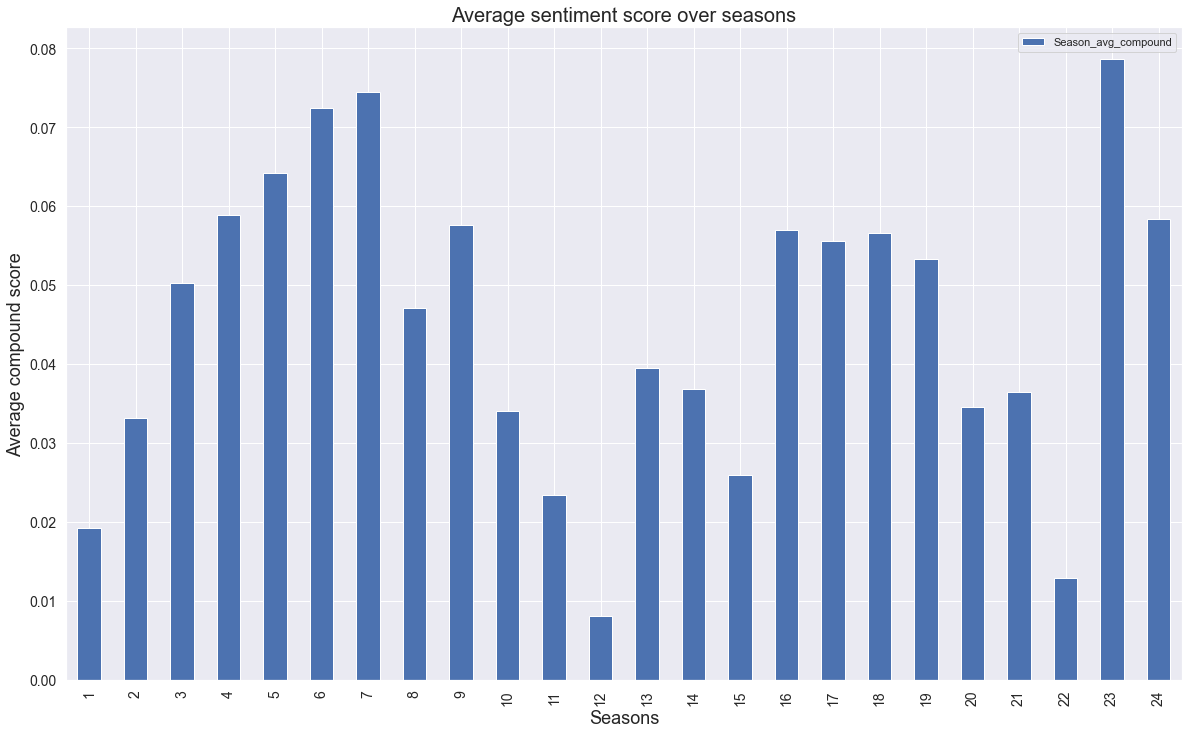

In [24]:
df_lines.groupby(['Season']).agg(Season_avg_compound=('compound', 'mean')) \
                            .plot(y='Season_avg_compound',kind='bar',figsize=(20,12), ylabel='Average compound score')
plt.ylabel('Average compound score', fontsize=18)
plt.xlabel('Seasons', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Average sentiment score over seasons', fontsize=20)
plt.show()

We can see an upward and downward trend of average sentiment over seasons. However, looking at the result, we might be surprised. Most people would expect mostly negative sentiment, where on our result we can see that average sentiment for seasons are neutral (compound score > -0.05 and compound score < 0.05) or positive (compound score >= 0.05). Because of this, we decided to check who looks general distribution of dialogues sentiment scores:

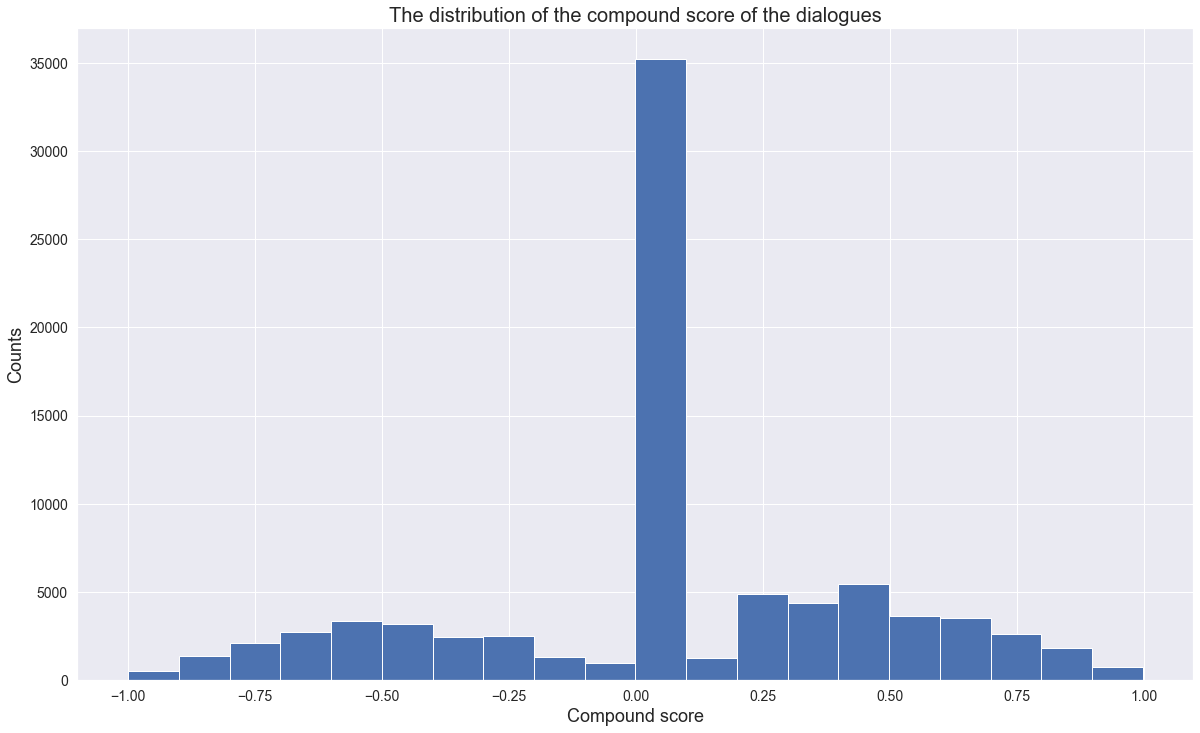

In [25]:
df_lines['compound'].plot(kind='hist', bins=20,figsize=(20,12))
plt.ylabel('Counts', fontsize=18)
plt.xlabel('Compound score', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('The distribution of the compound score of the dialogues', fontsize=20)
plt.show()

The results obtained show that just because we view South Park as negative does not mean that it will be classified in the same way. We have to remember that VADER and other sentiment classification are not perfect and can only determine the approximate value of the sentiment contained in the text. They are not always as able to determine the context of a statement or sarcasm as a human. Therefore, sometimes a text which is negative for a person will be evaluated as neutral or positive.

### Sentiment analysis through time - Main characters

After general episodes we decided to focus on 4 main characters and check how their sentiments evolve over time. The 4 main characters have very different personalities which is also something that we hope will be shown in the sentiment analysis.

As before we  will focus on dialogues of episodes. From data with episodes scripts and sentiment scores for each dialogue we filtered out those dialogues which belong to 4 main characters. 

In [27]:
main_character = ['Cartman', 'Kenny', 'Kyle', 'Stan']

In [28]:
df_char_lines = df_lines[df_lines.Character.isin(main_character)]

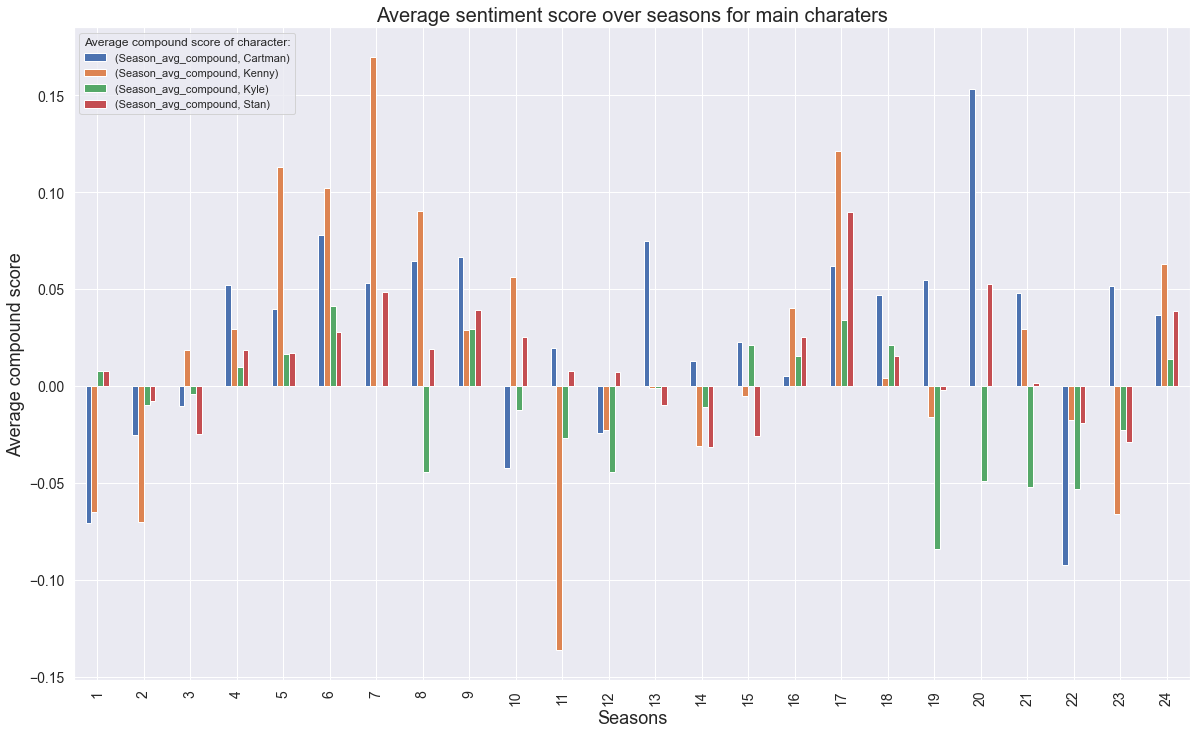

In [30]:
df_char_lines.groupby(['Season', 'Character']).agg(Season_avg_compound=('compound', 'mean')).unstack('Character')\
        .plot(kind='bar',figsize=(20,12), ylabel='Average compound score')
plt.ylabel('Average compound score', fontsize=18)
plt.xlabel('Seasons', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Average sentiment score over seasons for main charaters', fontsize=20)
plt.legend(title='Average compound score of character:')
plt.show()

As it can be seen the sentiment compound score almost evolves like a sinus curve. It is interesting to look at cartman, since he will be seen by many to very rude to other people. It is then interesting to see that he has a rather positive sentiment in many of the seasons. Even though Kenny doesn't say much (in fact he says normal things in an unintelligible way) he is one of the most emotionally powerful characters. This probably reflects that he is not the happiest guy in the show and comes from a less wealthy family and is always moped by the other characters. Kyle is mostly negative, but has some seasons where he is positive. Stan sentiment is neutral/positive through most of the seasons.

Analyzing the results we have to remember  that Vader does not understand sarcasm and context of dialogues, which are a big part of the show. This can also have influenced the score.

## Wordclouds 

To give a overview of the most used words on the character pages, for the 4 main characters, wordclouds can be created. The wordclouds will display the most common words with big text and the less common words with smaller text. 

In [83]:
main_characters = ["Eric Cartman", "Stan Marsh", "Kyle Broflovski", "Kenny McCormick"]
text = charactersText.values()
text = [item for sublist in text for item in sublist]

In [84]:
# Calculating idf
num_doc = len(main_characters)
idf_dic =  {}
for i in set(south_park_text):
    t_in_doc = 0
    for j in main_characters:
        if i in charactersText[j]:
            t_in_doc += 1
    idf_dic[i] = log(num_doc/(t_in_doc+1))

# calculating tf-idf
for i in main_characters:
    words = nltk.Text(charactersText[i])
    fdist1 = nltk.FreqDist(words)
    length = len(charactersText[i])
    charactersText[i+'_tf_idf'] = [(word+ " ") * (round(idf_dic[word])*freq) for word, freq in fdist1.items()]

NameError: name 'south_park_text' is not defined

In [85]:
for i in main_characters:
    text = " ".join(charactersText[i+'_tf_idf'])
    wordcloud = WordCloud(collocations=False,background_color="white").generate(text)
    plt.figure(figsize=(12,8))
    plt.title(i, size=36)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(i+".png", format="PNG")
    plt.show()

KeyError: 'Eric Cartman_tf_idf'

## Word Clouds for communities

In [452]:
text = communityText.values()
text = [item for sublist in text for item in sublist]

In [454]:
# Calculating idf
num_doc = len(list(communityText.keys()))
idf_dic =  {}
for i in set(text):
    t_in_doc = 0
    for j in list(communityText.keys()):
        if i in communityText[j]:
            t_in_doc += 1
    idf_dic[i] = log(num_doc/(t_in_doc+1))

# calculating tf-idf
for i in list(communityText.keys()):
    words = nltk.Text(communityText[i])
    fdist1 = nltk.FreqDist(words)
    length = len(communityText[i])
    communityText[i+'_tf_idf'] = [(word+ " ") * (round(idf_dic[word])*freq) for word, freq in fdist1.items()]

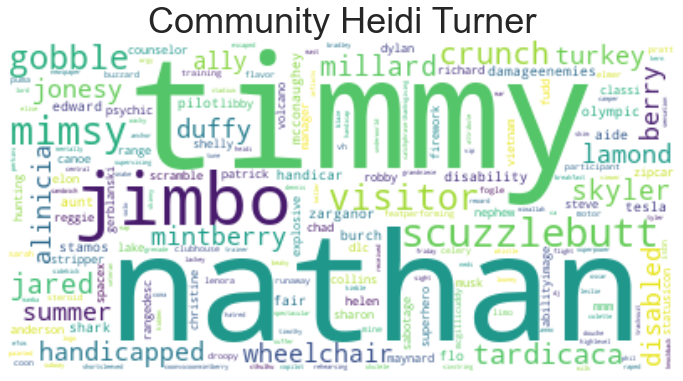

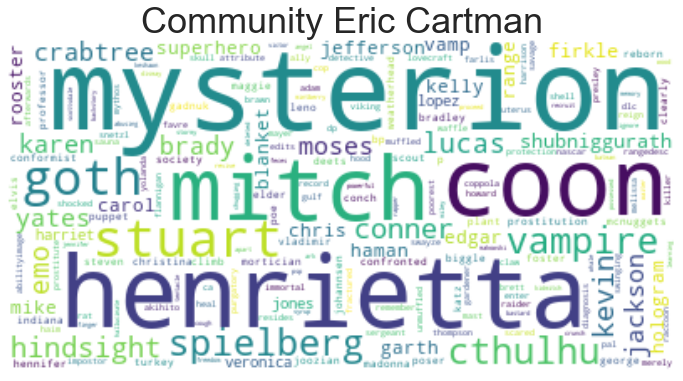

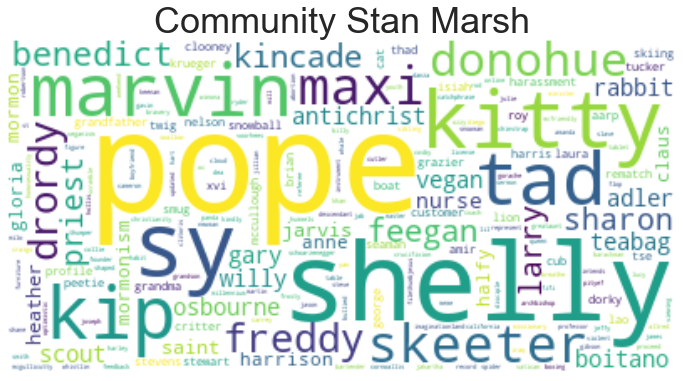

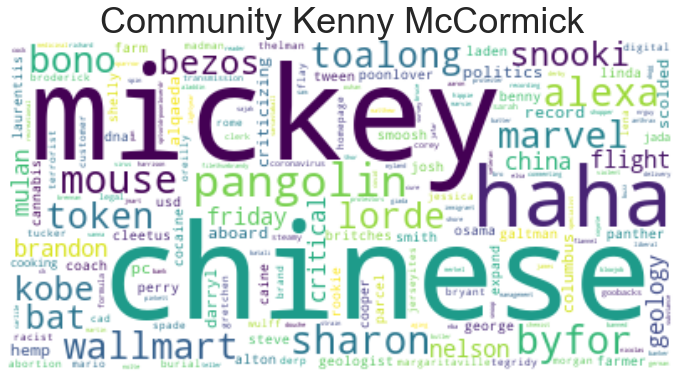

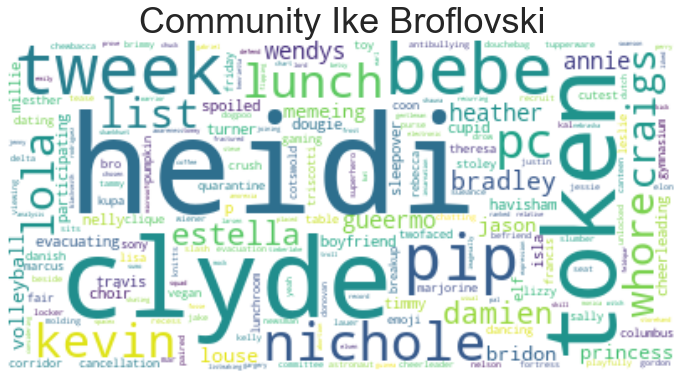

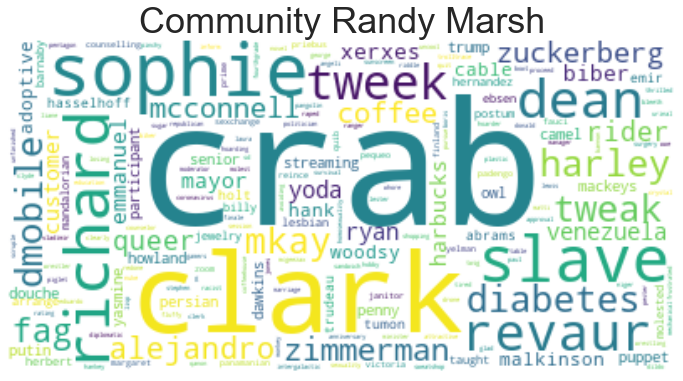

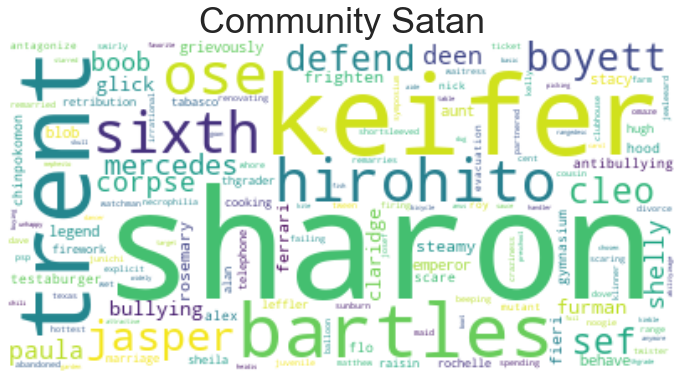

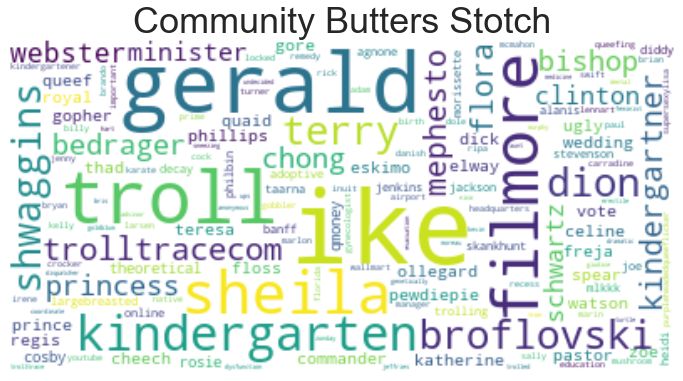

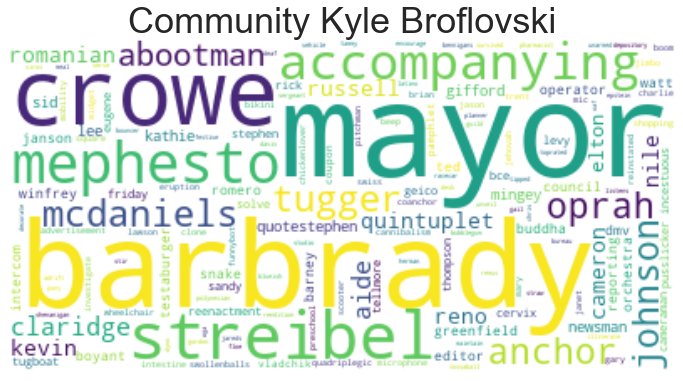

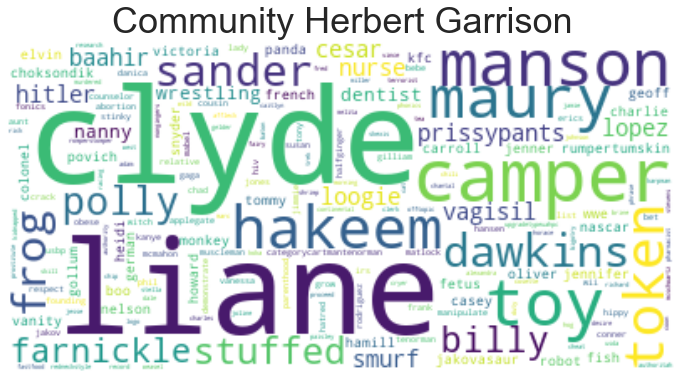

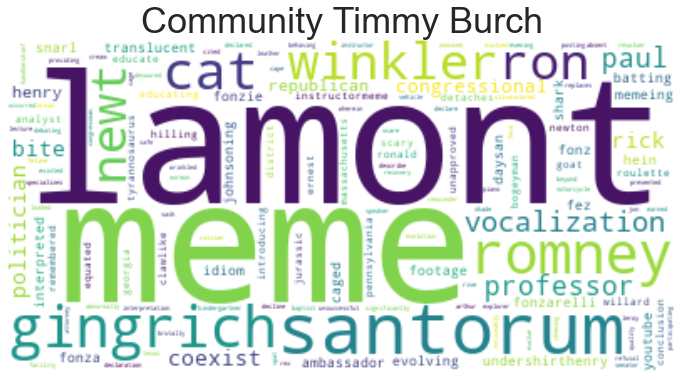

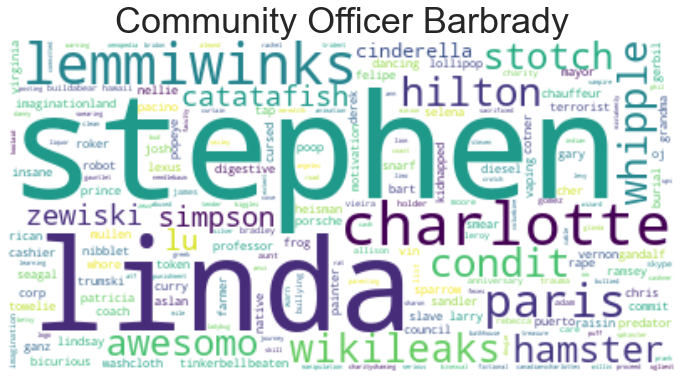

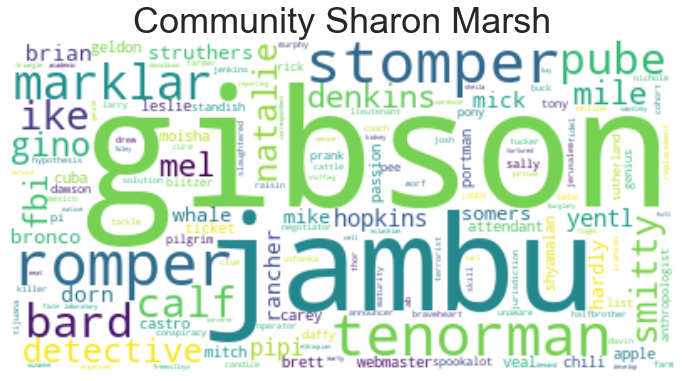

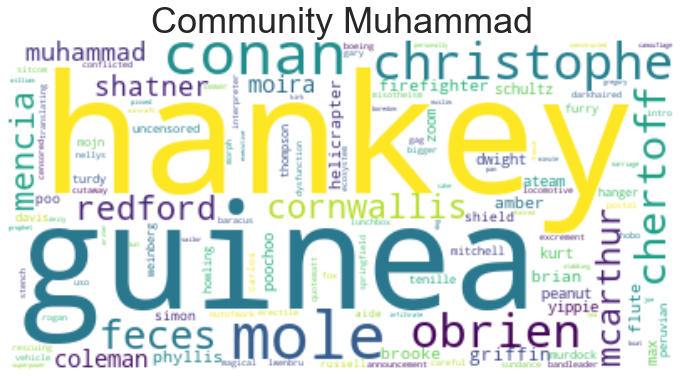

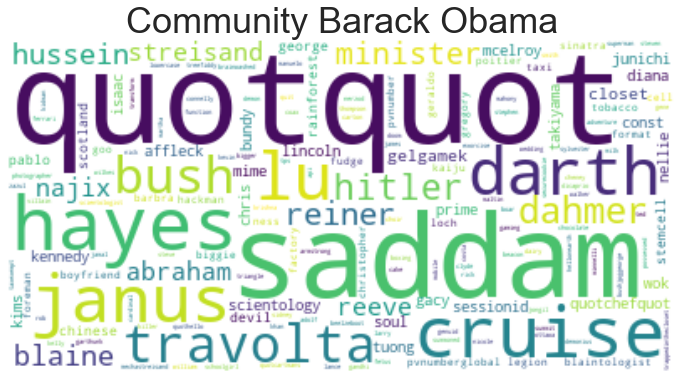

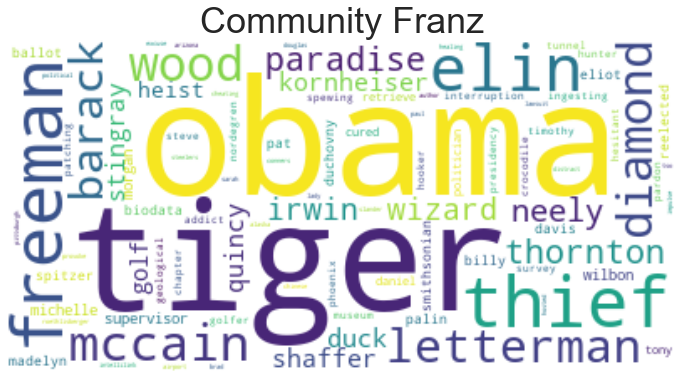

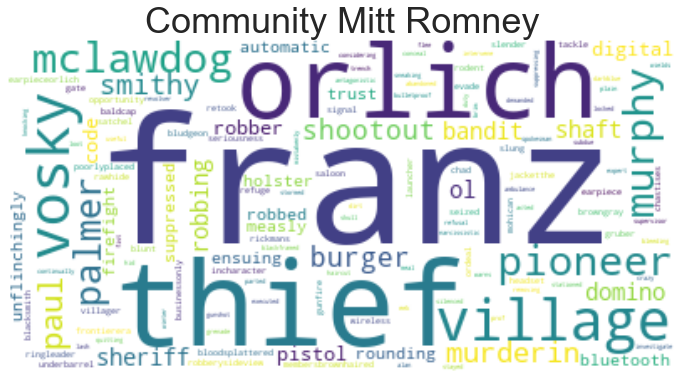

KeyError: 'Heidi Turner_tf_idf_tf_idf'

In [457]:
for i in list(communityText.keys())[0:17]:
    text = " ".join(communityText[i+'_tf_idf'])
    wordcloud = WordCloud(collocations=False,background_color="white").generate(text)
    plt.figure(figsize=(12,8))
    plt.title("Community "+i, size=36)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(i+".png", format="PNG")
    plt.show()